In [1]:
from rumor_centrality.graph_generator import scale_free
from rumor_centrality.graph_simulations import si
import rumor_centrality.rumor_detection as raw

In [2]:
infected_g = scale_free(100)
adj_list = raw.networkx_graph_to_adj_list(infected_g)

# Calculactions with and without factorial do not result in the same center nodes

Edit: Fixed, as @Tim forgot to preserves @Paul's idea, which was to omit factorial, and using the inverse of the p/t.

In [3]:
no_fact_lookup = raw.get_rumor_centrality_lookup(adj_list, use_fact=False)
fact_lookup = raw.get_rumor_centrality_lookup(adj_list, use_fact=True)

In [4]:
no_fact_max_value = max(no_fact_lookup.values())
[node for node, score in no_fact_lookup.items() if score == no_fact_max_value]

[2]

In [5]:
fact_max_value = max(fact_lookup.values())
[node for node, score in fact_lookup.items() if score == fact_max_value]

[2]

# Test with the Intro Talk Example

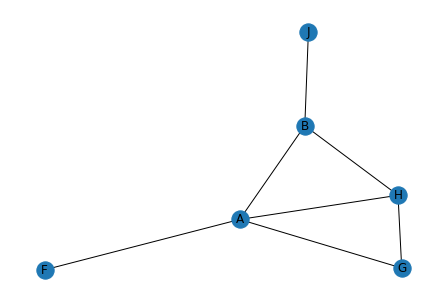

In [6]:
import networkx as nx
g = nx.Graph()
g.add_node("A")
g.add_node("B")
g.add_node("F")
g.add_node("G")
g.add_node("H")
g.add_node("J")

g.add_edge("A", "B")
g.add_edge("A", "F")
g.add_edge("A", "G")
g.add_edge("A", "H")

g.add_edge("B", "H")
g.add_edge("B", "J")

g.add_edge("G", "H")

nx.draw(g, with_labels=True)

In [7]:
# So all nodes are numbers again
mapping = {"A": 1, "B": 2, "F": 3, "G": 4, "H": 5, "J": 6}
reversed_mapping = dict([(number, letter) for letter, number in mapping.items()])

g = nx.relabel_nodes(g, mapping)

In [8]:
adj_list = raw.networkx_graph_to_adj_list(g)

In [9]:
no_fact_lookup = raw.get_rumor_centrality_lookup(adj_list, use_fact=False)
fact_lookup = raw.get_rumor_centrality_lookup(adj_list, use_fact=True)

In [10]:
dict([(reversed_mapping[node], score) for node, score in no_fact_lookup.items()])

{'A': 0.5,
 'B': 0.3333333333333333,
 'F': 0.1,
 'G': 0.125,
 'H': 0.25,
 'J': 0.06666666666666667}

In [11]:
dict([(reversed_mapping[node], score) for node, score in fact_lookup.items()])

{'A': 60.0, 'B': 40.0, 'F': 12.0, 'G': 15.0, 'H': 30.0, 'J': 8.0}

Neither of those is correct, the lookup using factorial gets the correct score for A, but is vastly off with all others, for example with B, which should also have been 60.

Either our code, or the intro talk example is wrong!

Edit: Our talk example was wrong!

# Simulation & Hop Distance

In [12]:
g = scale_free(100)
infected_g, centers = si(g, 100, 0.1, 1)

In [13]:
# Does not result in tree!
nx.is_tree(infected_g)

True

In [14]:
centers

[35]

In [15]:
adj_list = raw.networkx_graph_to_adj_list(infected_g)
lookup = raw.get_rumor_centrality_lookup(adj_list, use_fact=False)
sorted(lookup.items(), key=lambda x: x[1], reverse=True)

[(27, 1.0), (35, 1.0)]

In [16]:
prediction = raw.get_center_prediction(adj_list, use_fact=False)
prediction

[27, 35]

In [17]:
nodes_on_shortest_path = nx.shortest_path(g, centers[0], prediction[0])
hop_distance = len(nodes_on_shortest_path) - 1
hop_distance

1

In [26]:
import rumor_centrality.jordan_center_alternative as jo
from rumor_centrality.graph_visualization import plot_nx_graph

def benchmark_by_hop_distance(x):
    nodes = 1000
    g = nx.Graph(scale_free(nodes))
    infected_g, centers = si(g, 100, 0.1, 1)
        
    adj_list = raw.networkx_graph_to_adj_list(infected_g)
    
    rc_prediction = raw.get_center_prediction(adj_list, use_fact=False)
    jo_prediction = jo.centers_by_jordan_center(infected_g)
    bc_prediction = jo.centers_by_betweenness_centrality(infected_g)
    dc_prediction = jo.centers_by_distance_centrality(infected_g)
    
    predictions = [rc_prediction, jo_prediction, bc_prediction, dc_prediction]
    
    hop_distances = []
    for pred in predictions:
        hop_distances.append(nx.shortest_path_length(g, centers[0], pred[0]))
    return hop_distances

In [27]:
from tqdm import tqdm
from multiprocessing import Pool
with Pool(64) as p:
    hop_distances = p.map(benchmark_by_hop_distance, tqdm(range(200)))

100%|█████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 67221.80it/s]


In [28]:
import numpy as np

x = list(set([h for distances in hop_distances for h in distances]))
x = np.array(x)

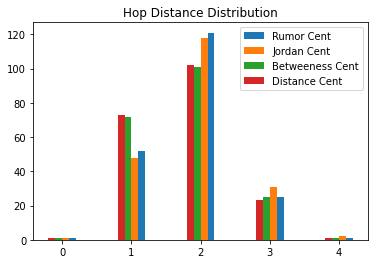

In [36]:
import matplotlib.pyplot as plt

labels = ["Rumor Cent", "Jordan Cent", "Betweeness Cent", "Distance Cent"]

fig, ax = plt.subplots(1,1)

for i in range(4):
    _hd = [d[i] for d in hop_distances]
    height = [_hd.count(d) for d in x]
    ax.bar(x - 0.1 * i + 0.15, height, label=labels[i], width=.1)
    ax.set_title("Hop Distance Distribution")
    ax.legend()